In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

# Import training_order_data

In [2]:
order_info_read = pd.read_csv('data/training_order_data.csv')

In [3]:
order_info = order_info_read.sort_values('time_stamp')

In [4]:
order_info.columns = ['initial_row', 'order_id', 'driver_id', 'passenger_id', \
                      'start_district_hash', 'dest_district_hash', 'price', 'time_stamp']

In [5]:
order_info.head()

,initial_row,order_id,driver_id,passenger_id,start_district_hash,dest_district_hash,price,time_stamp
262258,262258,9a864e958859b506f5f8bee9d8dfff17,a323121d71cd5247f38a4848c2039cb1,b9bd961ee676441d64c8748aa18efcda,b05379ac3f9b7d99370d443cfd5dcc28,52d7b69796362a8ed1691a6cc02ddde4,45,2016-01-01 00:00:03
231406,231406,6732f74a5a59353cddb421ceb39f7c26,a57d4acc407006cbb4086f0cc60d2575,37e17d1ec5ca26d52be702ce74db64a6,4725c39a5e5f4c188d382da3910b3f3f,929ec6c160e6f52c20a4217c7978f681,18,2016-01-01 00:00:04
210341,210341,f4beb0739bcee0f040385d69b9809b92,0b41511d4c63ed4bb030bd9d5ed5399e,b684445572045febd51a63a4e478b356,b05379ac3f9b7d99370d443cfd5dcc28,4725c39a5e5f4c188d382da3910b3f3f,31,2016-01-01 00:00:04
268247,268247,1f5672197a352594fb546d7164a41f28,90f993e801c394a351321377de6820b3,7d61be2772673f4fb728c867fba64833,82cc4851f9e4faa4e54309f8bb73fd7c,82cc4851f9e4faa4e54309f8bb73fd7c,10,2016-01-01 00:00:05
188962,188962,7bd83a5dd61f5242f82c52075ad43cbf,f5307b86a4d3da55e3626b9048d9b54a,d6c7bb502d01aed1c5031e17957e44ec,f47f35242ed40655814bc086d7514046,1cbfbdd079ef93e74405c53fcfff8567,24,2016-01-01 00:00:05


In [41]:
order_id = order_info['order_id']
driver_id = order_info['driver_id']
passenger_id = order_info['passenger_id']
start_district_hash = order_info['start_district_hash']
dest_district_hash = order_info['dest_district_hash']
price = order_info['price']
time_stamp = pd.to_datetime(order_info['time_stamp'])

In [42]:
order_id_num = len(order_id)
order_id_num_unique = len(order_id.unique())
print 'total order_id:', order_id_num
print 'unique order_id:', order_id_num_unique

total order_id: 8540614
unique order_id: 8518049


In [43]:
driver_id_null = pd.isnull(driver_id)
driver_id_num = len(driver_id)
driver_id_num_unique = len(driver_id.unique())
driver_id_num_null = len(driver_id[driver_id_null])
print 'total driver_id:', driver_id_num
print 'unique driver_id:', driver_id_num_unique
print 'null driver_id:', driver_id_num_null
print 'fraction of missed orders:', float(driver_id_num_null) / float(driver_id_num)
print 'fraction of received orders:', 1.0 - float(driver_id_num_null) / float(driver_id_num)

total driver_id: 8540614
unique driver_id: 93090
null driver_id: 1516460
fraction of missed orders: 0.177558662644
fraction of received orders: 0.822441337356


In [44]:
passenger_id = order_info['passenger_id']
passenger_id_num = len(passenger_id)
passenger_id_num_unique = len(passenger_id.unique())
print 'total passenger_id:', passenger_id_num
print 'unique passenger_id:', passenger_id_num_unique
print 'orders per passenger:', float(passenger_id_num) / float(passenger_id_num_unique)

total passenger_id: 8540614
unique passenger_id: 1368071
orders per passenger: 6.24281488315


# Track missed riders (ignoring null orders before the first accepted order)

In [111]:
minute = 10
t = np.arange(60*minute) # track the first 10 minutes after an null order
missed_rider_being_picked_up_num = np.zeros(t.shape)

missed_rider_timestamp = {}

### key: missed rider's hash value
### value: the first time_stamp of an null order 

delta_time = None

for i in range(order_id_num / 10): # only exploring tenth of data takes about half an hour on my laptop
    dri_id = driver_id.iloc[i]
    rid_id = passenger_id.iloc[i]
    tim_stp = time_stamp.iloc[i]
    if type(dri_id) == float and math.isnan(dri_id):
        if rid_id not in missed_rider_timestamp.keys():
            missed_rider_timestamp[rid_id] = time_stamp.iloc[i]
    elif rid_id in missed_rider_timestamp.keys():
        delta_time = time_stamp.iloc[i] - missed_rider_timestamp[rid_id]
        delta_second = int(delta_time.total_seconds())
        if delta_second < 60 * minute and delta_second > 0:
            missed_rider_being_picked_up_num[delta_second] += 1
        missed_rider_timestamp.pop(rid_id, None)
    if i % 20000 == 0:
        print i

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000


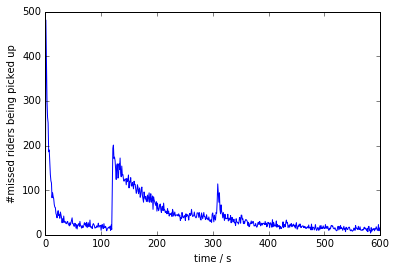

In [112]:
plt.plot(t,missed_rider_being_picked_up_num)
plt.xlabel('time / s')
plt.ylabel('#missed riders being picked up')
plt.show()

# Track missed riders (update to the latest null order)

In [113]:
minute = 10
t = np.arange(60*minute) # track the first 10 minutes after an null order
missed_rider_being_picked_up_num = np.zeros(t.shape)

missed_rider_timestamp = {}

### key: missed rider's hash value
### value: the first time_stamp of an null order 

for i in range(order_id_num / 10):
    dri_id = driver_id.iloc[i]
    rid_id = passenger_id.iloc[i]
    tim_stp = time_stamp.iloc[i]
    if type(dri_id) == float and math.isnan(dri_id):
        #if rid_id not in missed_rider_timestamp.keys():
        missed_rider_timestamp[rid_id] = time_stamp.iloc[i]   ### notice the difference here!!
    elif rid_id in missed_rider_timestamp.keys():
        delta_time = time_stamp.iloc[i] - missed_rider_timestamp[rid_id]
        delta_second = int(delta_time.total_seconds())
        if delta_second < 60 * minute and delta_second > 0:
            missed_rider_being_picked_up_num[delta_second] += 1
        missed_rider_timestamp.pop(rid_id, None)
    if i % 20000 == 0:
        print i

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000


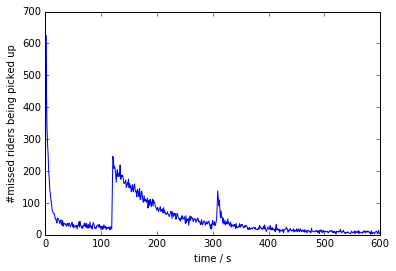

In [114]:
plt.plot(t,missed_rider_being_picked_up_num)
plt.xlabel('time / s')
plt.ylabel('#missed riders being picked up')
plt.show()